<div style="background-color:rgba(78, 188, 130, 0.05); text-align:center; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(78, 188, 130, 1.0); color: #000000;">

<img src="figs/qr_logo.png" width="700"/>

<h1><strong>Quantum Summer School</strong></h1>

<h2><strong>Episode 12</strong></h2>

<h3><strong>Variational Algorithms I: QAOA</strong></h3>

</div>

*In this session, we will learn about the quantum approximate optimization algorithm!*

<div style="background-color:rgba(255, 248, 240, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(255, 142, 0, 1.0); color: #000000;">

## Objectives
1. Understand the concept behind QAOA
2. Apply QAOA to the max-cut problem
3. Apply QAOA to the minimum vertex cover problem

<div/>

## Setup & Imports

In [2]:
from QuantumRingsLib import QuantumRingsProvider, job_monitor
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from quantumrings.toolkit.qiskit import QrBackendV2, QrSamplerV2, QrEstimatorV1
from qiskit.circuit.library import RXGate, RZGate
!pip -q install qiskit-algorithms
from qiskit_algorithms import QAOA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import COBYLA
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_histogram
from qiskit.primitives import Sampler
import numpy as np
!pip -q install networkx
import networkx as nx
import matplotlib.pyplot as plt
!pip -q install scikit-optimize
from skopt import gp_minimize
from qiskit.circuit.library import QAOAAnsatz  # lightweight, primitives-free
from IPython.display import clear_output


provider  = QuantumRingsProvider(); provider.active_account()
backend = provider.get_backend('scarlet_quantum_rings')
tool_backend   = QrBackendV2(provider, num_qubits=4, shots=2048)
sampler        = QrSamplerV2(backend=tool_backend)
estimator      = QrEstimatorV1(backend=tool_backend)


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


# Helper Functions

jobCallback: dummy callback for Quantum Rings estimator

In [3]:
def jobCallback(job_id, state, job):
    pass

pauli_string: returns a string of paulis with the given paulis at the given indices (ex: nodes=[2,3], paulis=['Z','X'] will return 'IIZXI')

In [4]:
def pauli_string(num_nodes, nodes, paulis):

    if isinstance(nodes, int):
        nodes = [nodes]
        
    string = ''
    pauli_dict = dict(zip(nodes, paulis))

    for i in range(num_nodes):
        string += pauli_dict.get(i, 'I')

    return string

get_graph: returns a graph given a set of edges, with the option to draw the graph

In [5]:
def get_graph(edges, draw=True):

    graph = nx.Graph(edges)
    positions = nx.spring_layout(graph, seed=1)

    if draw:
        nx.draw(graph, with_labels=True, pos=positions)
        plt.show()

    return graph

plot_cuts: Plots the cut edges on a graph given its partition

In [6]:
def plot_cuts(graph, partition):
    
    colors = ["tab:red" if i in partition[0] else "tab:blue" for i in graph.nodes]
    
    edge_colors = []
    for i,j in graph.edges:
        if i in partition[0] and j in partition[1]:
            edge_colors.append('tab:green')
        elif i in partition[1] and j in partition[0]:
            edge_colors.append('tab:green')
        else:
            edge_colors.append('tab:grey')
        
    pos = nx.spring_layout(graph, seed=1)
    default_axes = plt.axes(frameon=True)
    nx.draw(graph, node_color=colors, edge_color=edge_colors, node_size=100, alpha=0.8, pos=pos)
    plt.show()

# 1. QAOA Unitaries

## Drawing Graphs

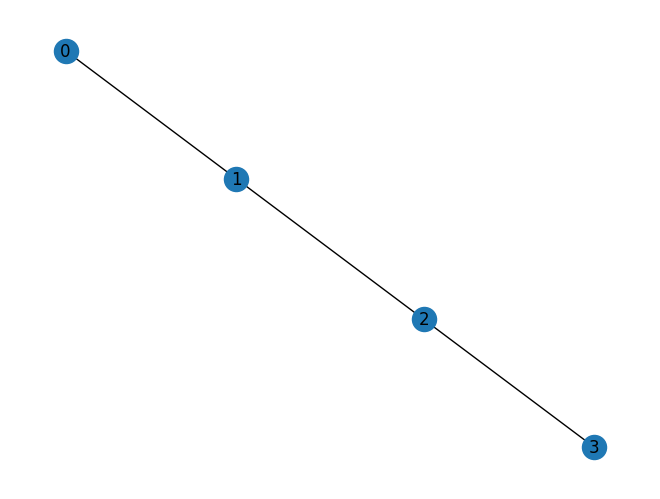

In [7]:
edges = [(0, 1), (1, 2), (2, 3)]
graph = nx.Graph(edges)
positions = nx.spring_layout(graph, seed=1)

nx.draw(graph, with_labels=True, pos=positions)
plt.show()

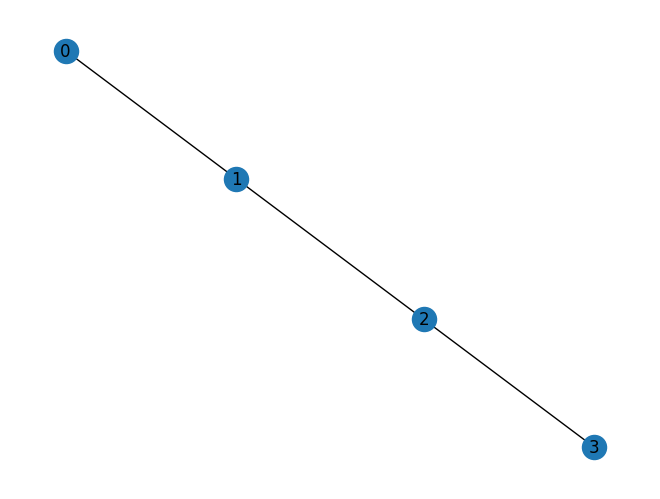

In [8]:
edges = [(0, 1), (1, 2), (2, 3)]
graph = get_graph(edges)

In [9]:
print('Vertices:', graph.nodes)
print('Edges:', graph.edges)

Vertices: [0, 1, 2, 3]
Edges: [(0, 1), (1, 2), (2, 3)]


# Cost and Mixer Unitaries

<div style="background-color:rgba(255, 245, 253, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(255, 142, 235, 1.0); color: #000000;">

An example cost Hamiltonian for our 1D chain of length $N$ is:

$$ H = \sum_{i=1}^{N-1} \sigma^z_i \sigma^z_{i+1} $$

Let's think about what this cost function represents. Recall that:

$$ z = 1 - 2x $$

So when $x=0$, $z=1$, and when $x=1$, $z=-1$. Let's define that 0 means we are not selecting that vertex and 1 means we are selecting that vertex. For example $|1011\rangle$ would mean we have selected vertices 0, 2, and 3, but not 1.

Consider one term in our Hamiltonian: $\sigma^z_i \sigma^z_{i+1}$. Note that all the basis states (such as $|1011\rangle$) are eigenstates of H. There are four possibilities:

| Qubit $i$ state     | Qubit $i+1$ state     | Energy ($\langle H \rangle$)    |
|--------------|--------------|--------------|
| 0 | 0 | 1 |
| 0 | 1 | -1 |
| 1 | 0 | -1 |
| 1 | 1 | 1 |

We can see that when the two qubits are in the same state, the energy is 1, and when the two qubits are in different states, the energy is -1. This cost Hamiltonian penalizes when the qubits are in the same state, since being in different states is more energetically favorable. In other words, this cost Hamiltonian's ground state will have the most instances where only one vertex is selected in a neighboring pair.

How do we implement our unitary: $U_C(\gamma) = e^{-i \gamma H}$? Since all the terms in $H$ commute with each other, we can further break this down as: $U_C(\gamma) = \prod_{i=1}^{N-1} e^{-i \gamma \sigma^z_i \sigma^z_{i+1}}$. This is simply a product of controlled z-rotations of angle $2\gamma$.

**Challenge:** Can you convince yourself that $e^{-i \gamma \sigma^z_i \sigma^z_{i+1}} = CR_z(2\gamma)$ controlled on one qubit, targeting the other (order doesn't matter)?

<div/>

In [10]:
# Define the cost operator U(gamma)
def U_cost(graph, gamma):
    
    num_nodes = len(graph.nodes)
    qc = QuantumCircuit(num_nodes)
    
    for i, j in graph.edges:
        qc.cx(i,j)
        qc.rx(2*gamma,j)
        qc.cx(i,j)

    return qc

In [11]:
qc = U_cost(graph, np.pi/3)
qc.draw()

q_0: ──■────────────────■──────────────────────────────────────────────
     ┌─┴─┐┌──────────┐┌─┴─┐                                            
q_1: ┤ X ├┤ Rx(2π/3) ├┤ X ├──■────────────────■────────────────────────
     └───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐                      
q_2: ──────────────────────┤ X ├┤ Rx(2π/3) ├┤ X ├──■────────────────■──
                           └───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐
q_3: ────────────────────────────────────────────┤ X ├┤ Rx(2π/3) ├┤ X ├
                                                 └───┘└──────────┘└───┘

The mixer operator needs to be orthogonal to the cost operator, so that the phase changes from the cost operator "turn into" probabilities of measuring 0 vs. 1. We use the following Hamiltonian:

$$ H = \sum_{i=1}^{N-1} \sigma^x_i $$

which corresponds to:

$$ U_B(\beta) = \prod_{i=1}^{N-1} e^{-i \gamma \sigma^x_i}$$

In [12]:
# Define the mixer operator U(beta)
def U_mix(graph, beta):
    num_nodes = len(graph.nodes)
    qc = QuantumCircuit(num_nodes)
    for i in range(num_nodes): 
        qc.rx(2*beta,i)
    return qc

In [13]:
qc = U_mix(graph, np.pi/4)
qc.draw()

┌─────────┐
q_0: ┤ Rx(π/2) ├
     ├─────────┤
q_1: ┤ Rx(π/2) ├
     ├─────────┤
q_2: ┤ Rx(π/2) ├
     ├─────────┤
q_3: ┤ Rx(π/2) ├
     └─────────┘

# 2. Max-Cut Problem

<div style="background-color:rgba(243, 248, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(101, 174, 247, 1.0); color: #000000;">

The Max-Cut Problem is as follows. Suppose you have a connected graph. You want to partition the graph into two sets, i.e. selecting some subset of the vertices and not selecting the rest. You cut the edges between any two neighbors which are in different sets. What is the partition which yields the maximum number of cut edges?

</div>

## Example 1

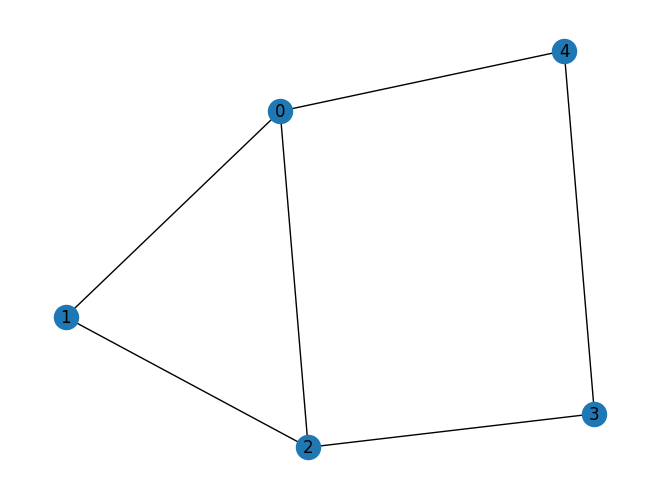

In [14]:
edges = [(0, 1), (0, 2), (0, 4), (1, 2), (2, 3), (3, 4)]
graph = get_graph(edges)

Best cut size: 5
Partition: ({2, 4}, {0, 1, 3})


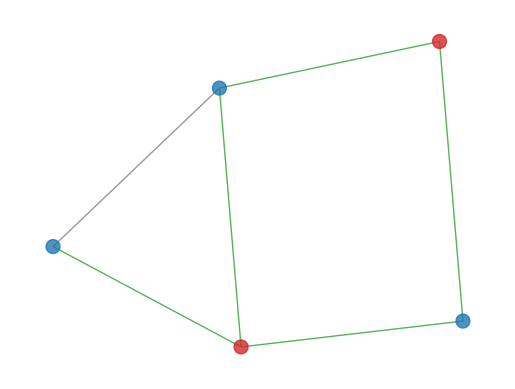

In [15]:
maxcut, partition = nx.approximation.one_exchange(graph, seed=1)
print("Best cut size:", maxcut)
print("Partition:", partition)
plot_cuts(graph, partition)

## Example 2

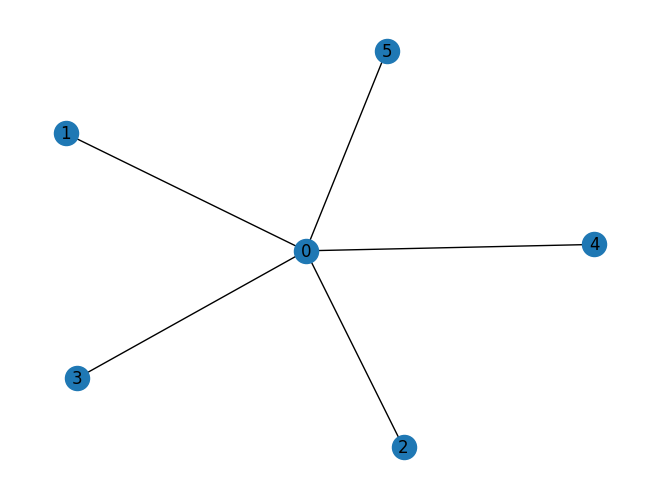

In [16]:
edges = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
graph = get_graph(edges)

Best cut size: 5
Partition: ({0}, {1, 2, 3, 4, 5})


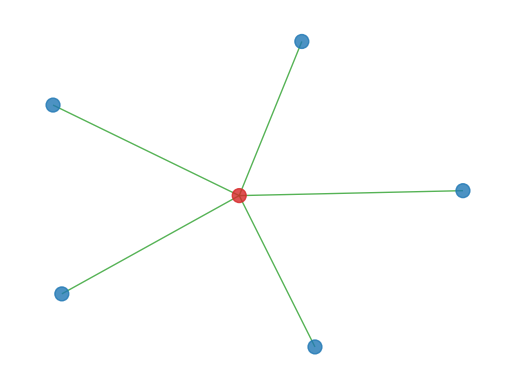

In [17]:
maxcut, partition = nx.approximation.one_exchange(graph, seed=1)
print("Best cut size:", maxcut)
print("Partition:", partition)
plot_cuts(graph, partition)

## Example 3

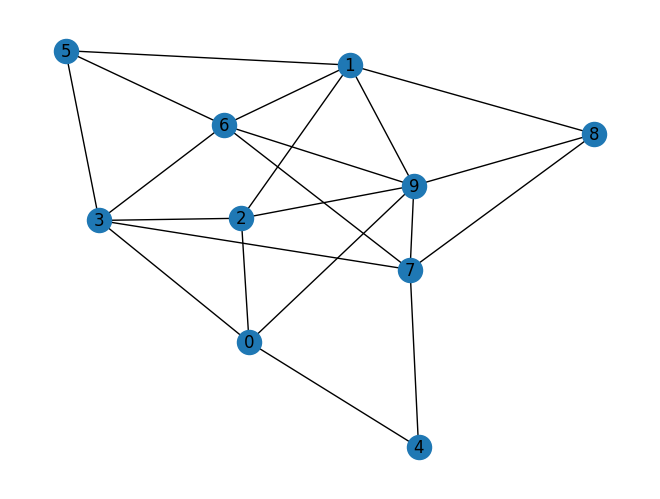

In [18]:
edges = [
    (0, 2), (0, 3), (0, 4),  (0, 9),
    (1, 2),  (1, 5), (1, 6), (1, 8), (1, 9),
    (2, 3),  (2, 9),
    (3, 5), (3, 6), (3, 7),
    (4, 7),
    (5, 6),
    (6, 7), (6, 9),
    (7, 8), (7, 9),
    (8, 9)
]
graph = get_graph(edges)

Best cut size: 16
Partition: ({9, 3, 4, 1}, {0, 2, 5, 6, 7, 8})


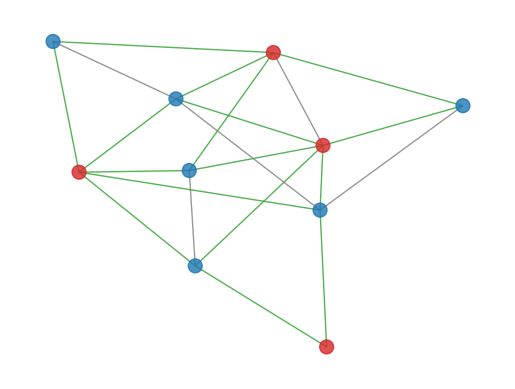

In [19]:
maxcut, partition = nx.approximation.one_exchange(graph, seed=1)
print("Best cut size:", maxcut)
print("Partition:", partition)
plot_cuts(graph, partition)

## QAOA Algorithm

What is the max cut partition for the following graph? What do we hope to get as a result of our QAOA algorithm?

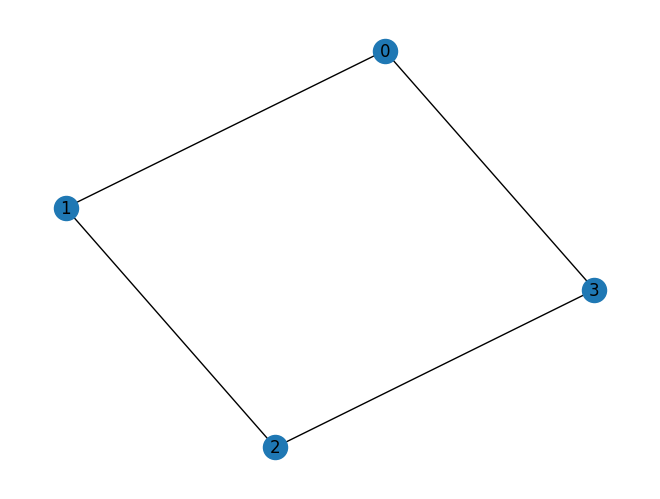

In [20]:
edges = [(0, 1), (1, 2), (2, 3), (3, 0)]
graph = get_graph(edges)

We first need to define our cost Hamiltonian. We want to penalize two neighboring vertices for being in the same set. We saw a Hamiltonian like this earlier in the notebook! If $E(G)$ is the set of edges in our graph, then our cost Hamiltonian should be:

$$ H = \sum_{\langle i,j \rangle\in E(G)} \sigma^z_i \sigma^z_{j} $$

So our unitary is:

$$U_C(\gamma) = \prod_{\langle i,j \rangle\in E(G)} e^{-i \gamma \sigma^z_i \sigma^z_{j}} = \prod_{\langle i,j \rangle\in E(G)} CR_{z,\langle i,j \rangle}(2\gamma)$$

In [21]:
# Define the operator U_C(gamma)
def U_cost(graph, gamma):
    num_nodes = len(graph.nodes)
    qc = QuantumCircuit(num_nodes)
    
    for i, j in graph.edges:
        qc.cx(i, j)
        qc.rz(2 * gamma, j)
        qc.cx(i, j)

    return qc

Define a function for computing the energy for a given bitstring. This way we can compute an approximation for the expectation value of $H$.

In [22]:
def bitstring_to_energy(bitstring, graph):
    total = 0

    for i,j in graph.edges:
        if bitstring[i] != bitstring[j]:
            total-=1
        else:
            total+=1

    return total

Define the QAOA circuit.

In [23]:
# QAOA circuit simulation
def QAOA_state(graph, gammas, betas, shots=1000, get_expectation_value=True, draw_circuit=False):
    
    num_nodes = len(graph.nodes)
    qr = QuantumRegister(num_nodes)
    cr = ClassicalRegister(num_nodes)
    qc = QuantumCircuit(qr, cr)

    # create equal superposition state
    qc.h(qr)
    # apply layers
    for i in range(len(gammas)):
        qc.compose(U_cost(graph, gammas[i]), inplace=True)
        qc.compose(U_mix(graph, betas[i]), inplace=True)
    qc.measure(qr, cr)

    if draw_circuit:
        display(qc.draw())

    job = tool_backend.run(qc, shots=shots)
    job.wait_for_final_state(0, 5, jobCallback)
    counts = job.result().get_counts()

    if get_expectation_value:
        total = 0
        for bitstring, count in counts.items():
            bitstring = bitstring[::-1]  # reverse due to qiskit ordering
            total += bitstring_to_energy(bitstring, graph) * count
        return total / shots
    else:
        return counts

┌───┐                                                     ┌─────────┐»
q0_0: ┤ H ├──■───────────────■────■──────────────────────────■──┤ Rx(π/2) ├»
      ├───┤┌─┴─┐┌─────────┐┌─┴─┐  │                          │  └─────────┘»
q0_1: ┤ H ├┤ X ├┤ Rz(π/3) ├┤ X ├──┼───────■──────────────────┼───────■─────»
      ├───┤└───┘└─────────┘└───┘  │     ┌─┴─┐   ┌─────────┐  │     ┌─┴─┐   »
q0_2: ┤ H ├───────────────────────┼─────┤ X ├───┤ Rz(π/3) ├──┼─────┤ X ├───»
      ├───┤                     ┌─┴─┐┌──┴───┴──┐└─────────┘┌─┴─┐   └───┘   »
q0_3: ┤ H ├─────────────────────┤ X ├┤ Rz(π/3) ├───────────┤ X ├───────────»
      └───┘                     └───┘└─────────┘           └───┘           »
c0: 4/═════════════════════════════════════════════════════════════════════»
                                                                           »
«                            ┌─┐                         
«q0_0: ──────────────────────┤M├─────────────────────────
«      ┌─────────┐           └╥┘┌─┐                      
«q0_1: ┤ Rx(π/2) ├────────────╫─┤M├──────────────────────
«      └─────────┘            ║ └╥┘     ┌─────────┐┌─┐   
«q0_2: ─────■─────────────────╫──╫───■──┤ Rx(π/2) ├┤M├───
«         ┌─┴─┐   ┌─────────┐ ║  ║ ┌─┴─┐├─────────┤└╥┘┌─┐
«q0_3: ───┤ X ├───┤ Rz(π/3) ├─╫──╫─┤ X ├┤ Rx(π/2) ├─╫─┤M├
«         └───┘   └─────────┘ ║  ║ └───┘└─────────┘ ║ └╥┘
«c0: 4/═══════════════════════╩══╩══════════════════╩══╩═
«                             0  1                  2  3

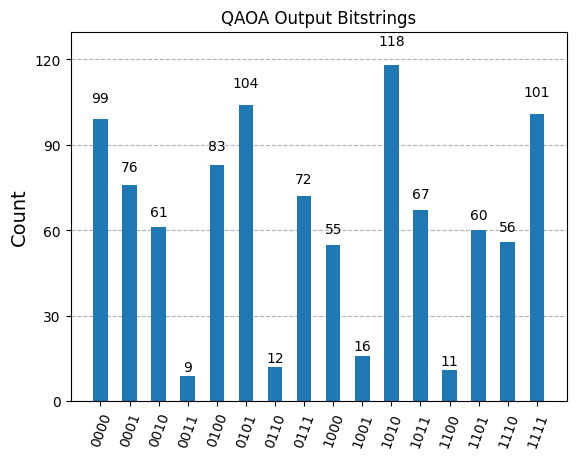

In [24]:
gammas = [np.pi/6]
betas = [np.pi/4]
counts = QAOA_state(graph, gammas, betas, shots=1000, get_expectation_value=False, draw_circuit=True)
plot_histogram(counts, bar_labels=True, title='QAOA Output Bitstrings')

## Optimizing $\vec{\gamma}$ and $\vec{\beta}$

In [25]:
# Cost function to minimize
def cost_function(x):
    
    gammas = x[:len(x)//2]
    betas = x[len(x)//2:]
    expectation_value = QAOA_state(graph, gammas, betas)

    return expectation_value

Best QAOA ⟨H⟩ = -1.844
Optimal angles = [18.36779068 66.62410494]


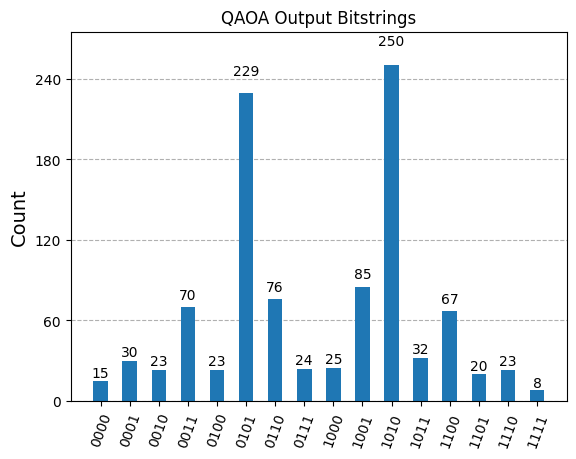

In [26]:
# Optimization
p = 1  # QAOA depth
theta0 = np.random.uniform(0, np.pi, 2 * p)
optimizer = COBYLA(maxiter=200)
res = optimizer.minimize(fun=cost_function, x0=theta0)

# Show optimization result
print("Best QAOA ⟨H⟩ =", round(res.fun, 4))
print("Optimal angles =", np.rad2deg(res.x))

# Extract angles and get final counts
gammas = res.x[:p]
betas = res.x[p:]
counts = QAOA_state(graph, gammas, betas, get_expectation_value=False)

# Plot histogram
plot_histogram(counts, bar_labels=True, title='QAOA Output Bitstrings')

Best QAOA ⟨H⟩ = -3.964
Optimal angles = [ 47.78331456 110.64367473 247.01741787  45.07858054]


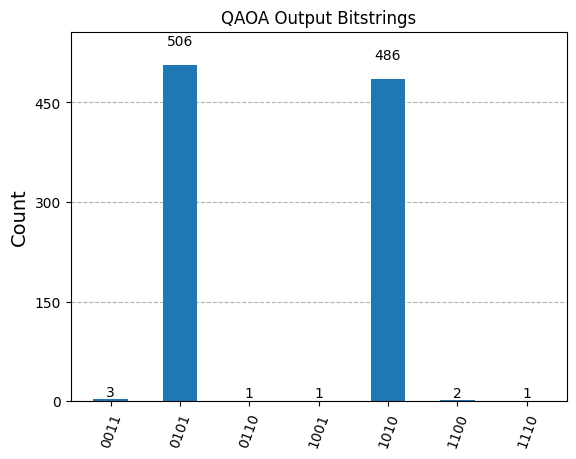

In [27]:
# Optimization
p = 2  # QAOA depth
theta0 = np.random.uniform(0, np.pi, 2 * p)
optimizer = COBYLA(maxiter=200)
res = optimizer.minimize(fun=cost_function, x0=theta0)

# Show optimization result
print("Best QAOA ⟨H⟩ =", round(res.fun, 4))
print("Optimal angles =", np.rad2deg(res.x))

# Extract angles and get final counts
gammas = res.x[:p]
betas = res.x[p:]
counts = QAOA_state(graph, gammas, betas, get_expectation_value=False)

# Plot histogram
plot_histogram(counts, bar_labels=True, title='QAOA Output Bitstrings')

Best QAOA ⟨H⟩ = -3.936
Optimal angles = [111.81189841  49.86444084  68.49620638  76.99169096 109.87996112
  21.075884  ]


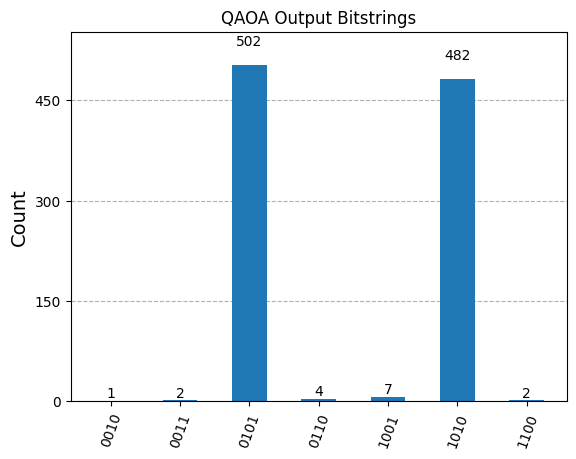

In [28]:
# Optimization
p = 3  # QAOA depth
theta0 = np.random.uniform(0, np.pi, 2 * p)
optimizer = COBYLA(maxiter=200)
res = optimizer.minimize(fun=cost_function, x0=theta0)

# Show optimization result
print("Best QAOA ⟨H⟩ =", round(res.fun, 4))
print("Optimal angles =", np.rad2deg(res.x))

# Extract angles and get final counts
gammas = res.x[:p]
betas = res.x[p:]
counts = QAOA_state(graph, gammas, betas, get_expectation_value=False)

# Plot histogram
plot_histogram(counts, bar_labels=True, title='QAOA Output Bitstrings')

<div style="background-color:rgba(252, 245, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(190, 111, 227, 1.0); color: #000000;">

### Challenge Problem: 

**A)** Try this out for other/larger graphs!

**B)** Can you think of any real-world applications for finding the maximum-cut of a graph?

<div/>

# 3. Minimum Vertex Cover

<div style="background-color:rgba(247, 255, 245, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(0, 153, 51, 1.0); color: #000000;">

The goal of minimum vertex cover is to cover the entire graph with the least number of selected vertices. What do we mean by cover? For each vertex we select, we can remove the edges connected to it. We are done when all edges are gone.

What should our cost Hamiltonian be? We want to penalize selecting vertices which share an edge, since we want the number of selected vertices to be minimal. If $x_i$ is the selection state of vertex i and $\langle i,j \rangle \in E(G)$, consider the term $(1-x_i)(1-x_j)$. If $x_i=x_j=0$, we get $1$. If $x_i=x_j=1$, we get $0$. If $x_i\neq x_j$, we get $0$. This makes sense. If neither is selected, that's bad because we missed an edge! But we need to add a term $x_i$ for each vertex to penalize selecting more vertices. This leads us to:

$$ H = P \sum_{\langle i,j \rangle \in E(G)} (1-x_i)(1-x_j) + \sum_{i \in V(G)} x_i $$

where $V(G)$ in the vertices of our graph and $P$ is the strength of penalty. Converting to Pauli-Zs, we get:

\begin{align}
H &= P \sum_{\langle i,j \rangle \in E(G)} \frac{1+\sigma^z_i}{2}\frac{1+\sigma^z_j}{2} + \sum_{i \in V(G)} \frac{1-\sigma^z_i}{2} \\
&= P \sum_{\langle i,j \rangle \in E(G)} \frac{1+\sigma^z_i+\sigma^z_j+\sigma^z_i\sigma^z_j}{4} + \sum_{i \in V(G)} \frac{1-\sigma^z_i}{2} \\
\end{align}

Dropping all constant shifts in energy and multiplying by 2, which do not change the distribution of energy eigenvalues/states, we get:

\begin{align}
H &= \frac{P}{2} \sum_{\langle i,j \rangle \in E(G)} \sigma^z_i+\sigma^z_j+\sigma^z_i\sigma^z_j - \sum_{i \in V(G)} \sigma^z_i \\
\end{align}

We can choose $P = 3/2$, which makes it a bit more energetically favorable to remove an edge than have one less vertex, to get:
\begin{align}
H &= \frac{3}{4} \sum_{\langle i,j \rangle \in E(G)} \sigma^z_i+\sigma^z_j+\sigma^z_i\sigma^z_j - \sum_{i \in V(G)} \sigma^z_i \\
\end{align}

</div>

First let's pick a graph.

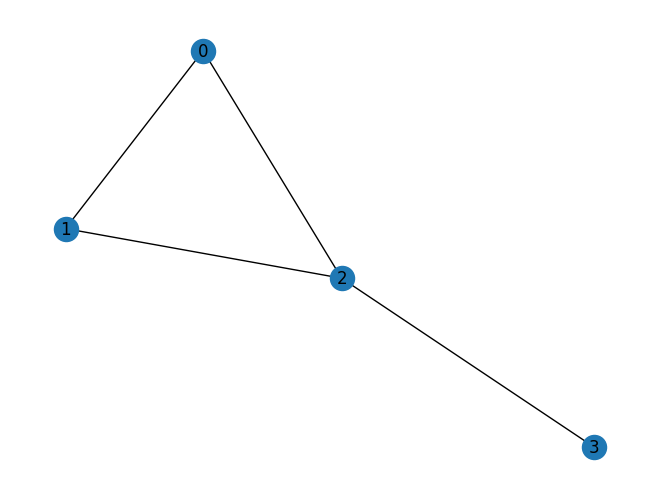

In [29]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = get_graph(edges)

**Question:** What are the possible minimum vertex covers?

Instead of building our unitaries from scratch, let's take advantage of Qiskit and the Quantum Rings Estimator, which can compute expectation values of an operator. We just need to define our cost Hamiltonian in the right way.

In [30]:
def H_cost(graph):

    num_nodes = len(graph.nodes)

    pauli_terms = []

    for i in range(num_nodes):

        term = pauli_string(num_nodes, i ,'Z')
        pauli_terms.append((term,-1))

    for i,j in graph.edges:

        term = pauli_string(num_nodes, i ,'Z')
        pauli_terms.append((term,3/4))

        term = pauli_string(num_nodes, j ,'Z')
        pauli_terms.append((term,3/4))

        term = pauli_string(num_nodes, [i,j] ,['Z','Z'])
        pauli_terms.append((term,3/4))

    H = SparsePauliOp.from_list(pauli_terms)
    
    return H

In [31]:
H_cost(graph)

SparsePauliOp(['ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZIII', 'IZII', 'ZZII', 'ZIII', 'IIZI', 'ZIZI', 'IZII', 'IIZI', 'IZZI', 'IIZI', 'IIIZ', 'IIZZ'],
              coeffs=[-1.  +0.j, -1.  +0.j, -1.  +0.j, -1.  +0.j,  0.75+0.j,  0.75+0.j,
  0.75+0.j,  0.75+0.j,  0.75+0.j,  0.75+0.j,  0.75+0.j,  0.75+0.j,
  0.75+0.j,  0.75+0.j,  0.75+0.j,  0.75+0.j])

In [32]:
# --- 1) Build a parameterised QAOA circuit -----------------------------
p       = 4                               # depth (=reps)
ansatz  = QAOAAnsatz(H_cost(graph), reps=p)      # uses your SparsePauliOp cost_h
n_theta = ansatz.num_parameters           # 2 p parameters: [β0..βp-1, γ0..γp-1]

# --- 2) Energy function that calls the Quantum Rings estimator ---------
def energy(theta_vector: np.ndarray) -> float:
    
    qc = ansatz.assign_parameters(theta_vector)   # substitute angles
    
    job = estimator.run(                          # <-- QrEstimatorV1
        circuits       = [qc],
        observables    = [H_cost(graph)],
        parameter_values=[[]]                      # no free params left
    )
        
    return job.result().values[0].real            # single expectation value

# --- 3) Classical optimisation with the new COBYLA API ----------------
optimizer  = COBYLA(maxiter=1000)
theta0     = np.random.uniform(0, np.pi, n_theta)   # random start
# theta0 = [np.pi/4]*2*p
res        = optimizer.minimize(fun=energy, x0=theta0)

print("Best QAOA ⟨H⟩ =", round(res.fun, 4))
print("Optimal angles =", np.rad2deg(res.x))

Best QAOA ⟨H⟩ = -2.6369
Optimal angles = [ 77.12770937  98.46096907  52.95335338 194.08589815 134.20530985
  98.30440342 128.95929106  34.67603718]


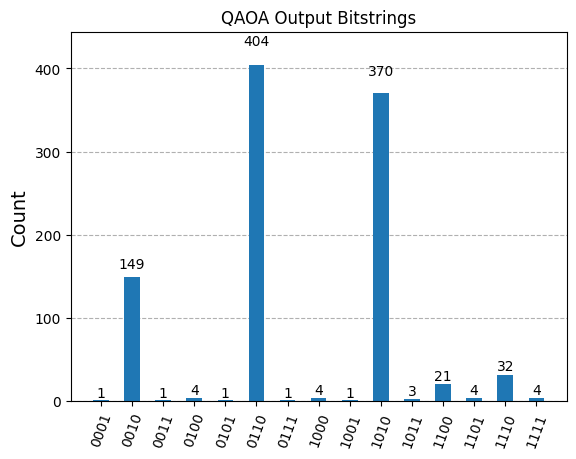

In [33]:
# Fetch the optimal gamma and beta values
x = res.x
# Execute the qaoa state with the optimal gamma and beta values
qc = ansatz.assign_parameters(x)
qc.measure_all()
job = tool_backend.run(qc, shots=1000)
job.wait_for_final_state(0, 5, jobCallback)
counts = job.result().get_counts()

plot_histogram(counts,bar_labels=True,title='QAOA Output Bitstrings')

<div style="background-color:rgba(252, 245, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(190, 111, 227, 1.0); color: #000000;">

### Challenge Problem: 

**A)** Try this out for other/larger graphs!

**B)** Can you think of any real-world applications for finding the minimum vertex cover?

<div/>